# GLM: Negative Binomial Regression

In [1]:
import re

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns

from scipy import stats

print(f"Running on PyMC3 v{pm.__version__}")

Running on PyMC3 v3.9.3


In [2]:
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")

This notebook demos negative binomial regression using the `glm` submodule. It closely follows the GLM Poisson regression example by [Jonathan Sedar](https://github.com/jonsedar) (which is in turn inspired by [a project by Ian Osvald](http://ianozsvald.com/2016/05/07/statistically-solving-sneezes-and-sniffles-a-work-in-progress-report-at-pydatalondon-2016/)) except the data here is negative binomially distributed instead of Poisson distributed.

Negative binomial regression is used to model count data for which the variance is higher than the mean. The [negative binomial distribution](https://en.wikipedia.org/wiki/Negative_binomial_distribution) can be thought of as a Poisson distribution whose rate parameter is gamma distributed, so that rate parameter can be adjusted to account for the increased variance.

### Generate Data

As in the Poisson regression example, we assume that sneezing occurs at some baseline rate, and that consuming alcohol, not taking antihistamines, or doing both, increase its frequency.

#### Poisson Data

First, let's look at some Poisson distributed data from the Poisson regression example.

In [3]:
# Mean Poisson values
theta_noalcohol_meds = 1  # no alcohol, took an antihist
theta_alcohol_meds = 3  # alcohol, took an antihist
theta_noalcohol_nomeds = 6  # no alcohol, no antihist
theta_alcohol_nomeds = 36  # alcohol, no antihist

# Create samples
q = 1000
df_pois = pd.DataFrame(
    {
        "nsneeze": np.concatenate(
            (
                np.random.poisson(theta_noalcohol_meds, q),
                np.random.poisson(theta_alcohol_meds, q),
                np.random.poisson(theta_noalcohol_nomeds, q),
                np.random.poisson(theta_alcohol_nomeds, q),
            )
        ),
        "alcohol": np.concatenate(
            (
                np.repeat(False, q),
                np.repeat(True, q),
                np.repeat(False, q),
                np.repeat(True, q),
            )
        ),
        "nomeds": np.concatenate(
            (
                np.repeat(False, q),
                np.repeat(False, q),
                np.repeat(True, q),
                np.repeat(True, q),
            )
        ),
    }
)

In [4]:
df_pois.groupby(["nomeds", "alcohol"])["nsneeze"].agg(["mean", "var"])

mean        var
nomeds alcohol                   
False  False     1.047   1.047839
       True      3.089   3.066145
True   False     6.002   6.156152
       True     36.004  35.781766

Since the mean and variance of a Poisson distributed random variable are equal, the sample means and variances are very close.

#### Negative Binomial Data

Now, suppose every subject in the dataset had the flu, increasing the variance of their sneezing (and causing an unfortunate few to sneeze over 70 times a day). If the mean number of sneezes stays the same but variance increases, the data might follow a negative binomial distribution.

In [5]:
# Gamma shape parameter
alpha = 10


def get_nb_vals(mu, alpha, size):
    """Generate negative binomially distributed samples by
    drawing a sample from a gamma distribution with mean `mu` and
    shape parameter `alpha', then drawing from a Poisson
    distribution whose rate parameter is given by the sampled
    gamma variable.

    """

    g = stats.gamma.rvs(alpha, scale=mu / alpha, size=size)
    return stats.poisson.rvs(g)


# Create samples
n = 1000
df = pd.DataFrame(
    {
        "nsneeze": np.concatenate(
            (
                get_nb_vals(theta_noalcohol_meds, alpha, n),
                get_nb_vals(theta_alcohol_meds, alpha, n),
                get_nb_vals(theta_noalcohol_nomeds, alpha, n),
                get_nb_vals(theta_alcohol_nomeds, alpha, n),
            )
        ),
        "alcohol": np.concatenate(
            (
                np.repeat(False, n),
                np.repeat(True, n),
                np.repeat(False, n),
                np.repeat(True, n),
            )
        ),
        "nomeds": np.concatenate(
            (
                np.repeat(False, n),
                np.repeat(False, n),
                np.repeat(True, n),
                np.repeat(True, n),
            )
        ),
    }
)

In [6]:
df.groupby(["nomeds", "alcohol"])["nsneeze"].agg(["mean", "var"])

mean         var
nomeds alcohol                    
False  False     1.005    1.134109
       True      3.099    4.255454
True   False     5.996    9.557542
       True     36.006  158.450414

As in the Poisson regression example, we see that drinking alcohol and/or not taking antihistamines increase the sneezing rate to varying degrees. Unlike in that example, for each combination of `alcohol` and `nomeds`, the variance of `nsneeze` is higher than the mean. This suggests that a Poisson distribution would be a poor fit for the data since the mean and variance of a Poisson distribution are equal.

### Visualize the Data

/home/amit/miniconda3/envs/pymc3/lib/python3.8/site-packages/seaborn/axisgrid.py:382: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout()


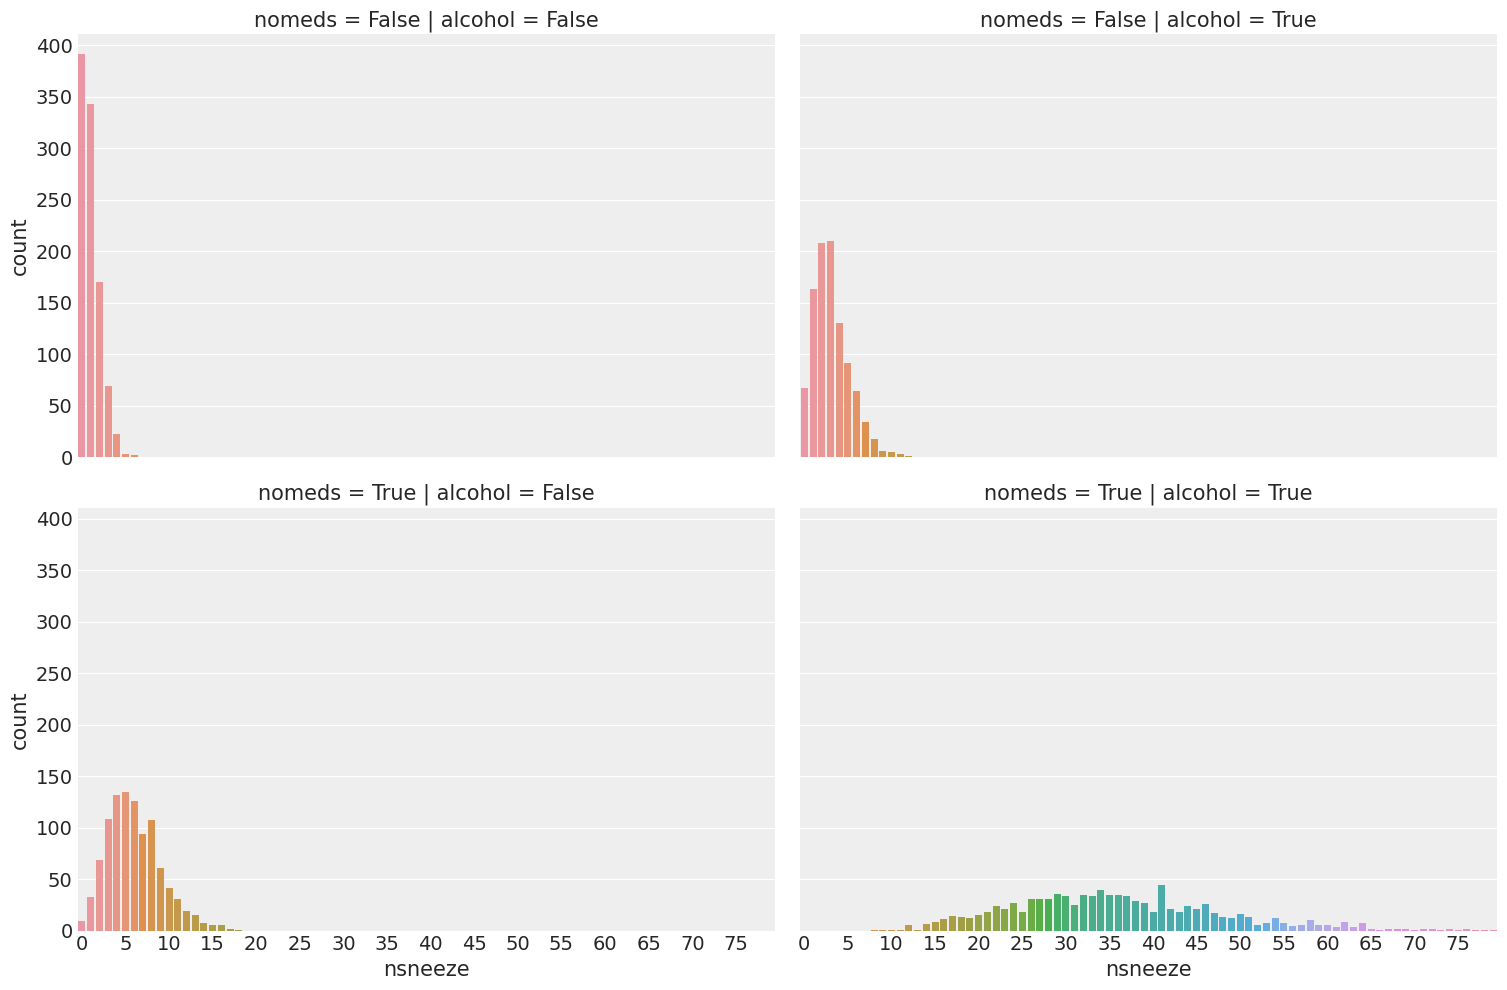

In [7]:
g = sns.catplot(x="nsneeze", row="nomeds", col="alcohol", data=df, kind="count", aspect=1.5)

# Make x-axis ticklabels less crowded
ax = g.axes[1, 0]
labels = range(len(ax.get_xticklabels(which="both")))
ax.set_xticks(labels[::5])
ax.set_xticklabels(labels[::5]);

## Negative Binomial Regression

### Create GLM Model

In [8]:
fml = "nsneeze ~ alcohol + nomeds + alcohol:nomeds"

with pm.Model() as model:
    pm.glm.GLM.from_formula(formula=fml, data=df, family=pm.glm.families.NegativeBinomial())
    trace = pm.sample(1000, tune=1000, cores=2, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, mu, alcohol[T.True]:nomeds[T.True], nomeds[T.True], alcohol[T.True], Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 73 seconds.


### View Results

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb2c4273ac0>,
      dtype=object)

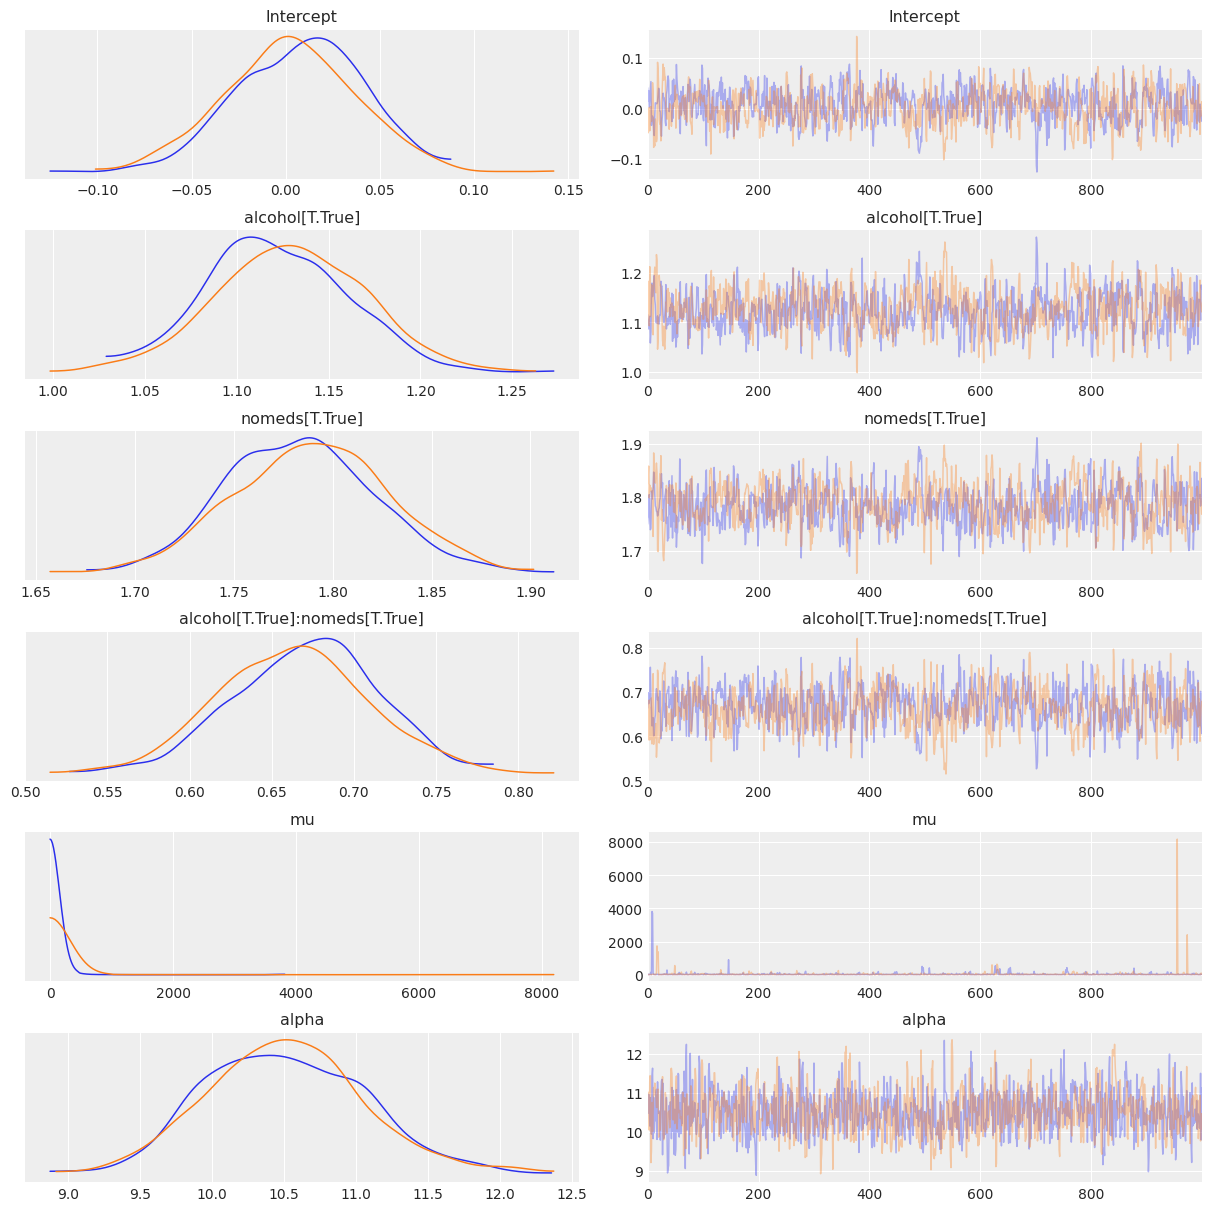

In [9]:
az.plot_trace(trace)

In [10]:
# Transform coefficients to recover parameter values
np.exp(az.summary(trace)[["mean", "hdi_3%", "hdi_97%"]])

,mean,hdi_3%,hdi_97%
Intercept,1.005013e+00,0.941765,1.068227e+00
alcohol[T.True],3.083299e+00,2.869105,3.330092e+00
nomeds[T.True],5.965543e+00,5.562235,6.417316e+00
alcohol[T.True]:nomeds[T.True],1.948383e+00,1.791405,2.114884e+00
mu,7.918673e+15,1.004008,1.019963e+38
alpha,3.682750e+04,13988.628101,1.135502e+05


The mean values are close to the values we specified when generating the data:
- The base rate is a constant 1.
- Drinking alcohol triples the base rate.
- Not taking antihistamines increases the base rate by 6 times.
- Drinking alcohol and not taking antihistamines doubles the rate that would be expected if their rates were independent. If they were independent, then doing both would increase the base rate by 3\*6=18 times, but instead the base rate is increased by 3\*6\*2=16 times.

Finally, even though the sample for `mu` is highly skewed, its median value is close to the sample mean, and the mean of `alpha` is also quite close to its actual value of 10.

In [11]:
np.percentile(trace.posterior["mu"], [25, 50, 75])

array([ 4.51997439, 10.06565279, 22.92079093])

In [12]:
df.nsneeze.mean()

11.5265

In [13]:
trace.posterior["alpha"].mean()

<xarray.DataArray 'alpha' ()>
array(10.5141582)

In [14]:
%load_ext watermark
%watermark -n -u -v -iv -w

seaborn 0.10.1
numpy   1.18.5
pymc3   3.9.3
pandas  1.0.5
re      2.2.1
arviz   0.9.0
last updated: Mon Oct 05 2020 

CPython 3.8.3
IPython 7.16.1
watermark 2.0.2
